In [17]:
from collections import defaultdict

import numpy as np
import torch
import torch.nn.functional as F

from monopoly_go import monopoly_go_v0
from monopoly_go.utils import flattened_length
from dqn import DQN, ReplayBuffer

device = torch.device("mps")

# Hyperparameters
num_episodes = 15000
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.999
epsilon_min = 0.05
batch_size = 128
lr = 1e-6
target_update_freq = 20

# Environment setup
env = monopoly_go_v0.env(render_mode="human")
env.reset()
sample_obs = env.observe("player_0")
obs_size = flattened_length
action_size = env.action_space("player_0").n

# Model + target
policy_net = DQN(obs_size, action_size).to(device)
target_net = DQN(obs_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
buffer = ReplayBuffer()

agent_to_train = "player_0"



In [18]:
winners = [0, 0, 0]

total_action_counts = {"player_0": defaultdict(int),
                       "player_1": defaultdict(int),
                       "player_2": defaultdict(int)}
completed_episodes = 0
losses = []
average_losses = []
wins = 0
win_rates = []
rewards = []
average_rewards = []
terminated = [False] * 3
for ep in range(num_episodes):
    env = monopoly_go_v0.env(render_mode="human")
    env.reset()
    last_obs = {}

    while True:
        agent = env.agent_selection
        obs, reward, term, trunc, info = env.last()

        if term:
            terminated[env.curr_agent_index] = True
            env.step(None)

        if not term and agent == agent_to_train:
            # ε-greedy policy
            if np.random.rand() < epsilon:
                action = env.action_space(agent).sample(info["action_mask"])
            else:
                with torch.no_grad():
                    obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
                    q_values = policy_net(obs_tensor)
                    mask = torch.tensor(info["action_mask"], dtype=torch.bool).unsqueeze(0)  # shape [1, 611]
                    assert mask.sum() > 0, "All actions masked — bug in masking logic"
                    q_values[~mask] = -float('inf')
                    action = torch.argmax(q_values).item()

            last_obs[agent] = obs
            last_action = action
        else:
            action = env.action_space(agent).sample(info["action_mask"])

        env.step(action if not term else None)

        if agent == agent_to_train:
            next_obs, r, done_flag, _, _ = env.last()
            rewards.append(r)
            if len(rewards) == 3000:
                average_rewards.append(np.mean(rewards))
                rewards = []
            buffer.add((last_obs[agent], last_action, r, next_obs, done_flag))

        if all(terminated):
            terminated = [False] * 3
            completed_episodes += 1
            break
    
    if env.winner >= 0:
        if env.winner == 0:
            wins += 1
        winners[env.winner] += 1

    if ep and ep % 200 == 0:
        win_rates.append(wins/200)
        wins = 0

    for agent in env.action_counts:
        for action in env.action_counts[agent]:
            total_action_counts[agent][action] += 1

    # Training step
    if len(buffer.buffer) >= batch_size:
        obs_b, act_b, rew_b, next_obs_b, done_b = buffer.sample(batch_size, device=device)
        obs_b = obs_b.float().to(device)
        act_b = act_b.long().to(device)
        rew_b = rew_b.float().to(device)
        next_obs_b = next_obs_b.float().to(device)
        done_b = done_b.float().to(device)

        q_vals = policy_net(obs_b).gather(1, act_b.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_q_vals = target_net(next_obs_b).max(1)[0]
            target = rew_b + gamma * next_q_vals * (1 - done_b)

        loss = F.mse_loss(q_vals, target)
        losses.append(loss.item())
        if len(losses) == 50:
            average_losses.append(np.mean(losses))
            losses = []
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Decay epsilon
    if ep >= 3000:
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
    # Update target network
    if ep % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    if ep and ep % 100 == 0:
        print(f"Episode {ep} done. ε={epsilon:.3f}")
        if win_rates:
            print(f"Latest win rate: {win_rates[-1]}")
        print(f"Latest average reward: {average_rewards[-1]}")
        print(f"Latest average loss: {average_losses[-1]}")

Episode 100 done. ε=1.000
Latest average reward: -11.265
Latest average loss: 6988.144638671875
Game over due to deck running out
Game over due to deck running out
Game over due to deck running out
Game over due to deck running out
Game over due to deck running out
Episode 200 done. ε=1.000
Latest win rate: 0.34
Latest average reward: -11.173333333333334
Latest average loss: 6956.386630859375
Game over due to deck running out
Game over due to deck running out
Game over due to deck running out
Game over due to deck running out
Episode 300 done. ε=1.000
Latest win rate: 0.34
Latest average reward: -11.771666666666667
Latest average loss: 7041.03015625
Game over due to deck running out
Game over due to deck running out
Episode 400 done. ε=1.000
Latest win rate: 0.33
Latest average reward: -11.685
Latest average loss: 7015.014306640625
Game over due to deck running out
Episode 500 done. ε=1.000
Latest win rate: 0.33
Latest average reward: -11.32
Latest average loss: 6839.7592578125
Game ov

KeyboardInterrupt: 

In [19]:
print(winners)

[3388, 3073, 3475]


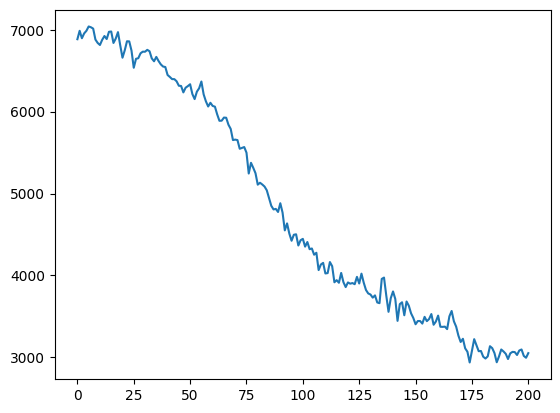

In [20]:
import matplotlib.pyplot as plt

plt.plot(average_losses)

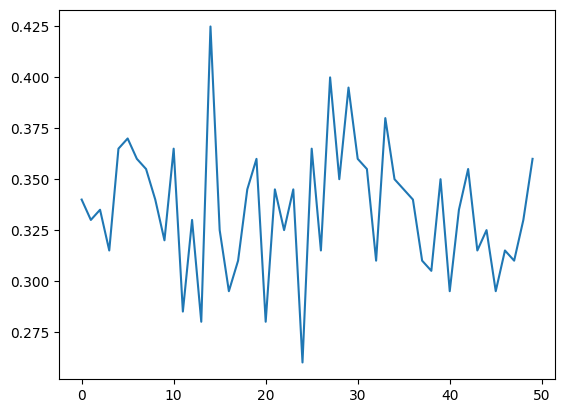

In [21]:
plt.plot(win_rates)

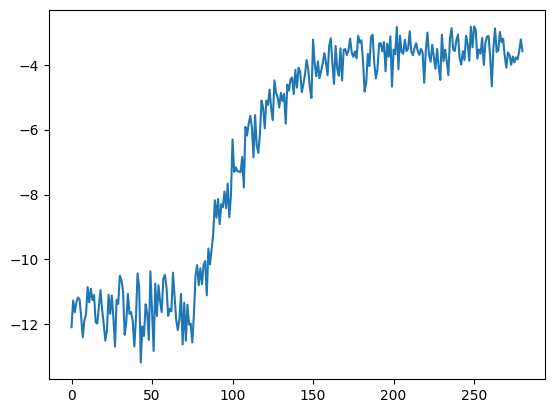

In [22]:
plt.plot(average_rewards)

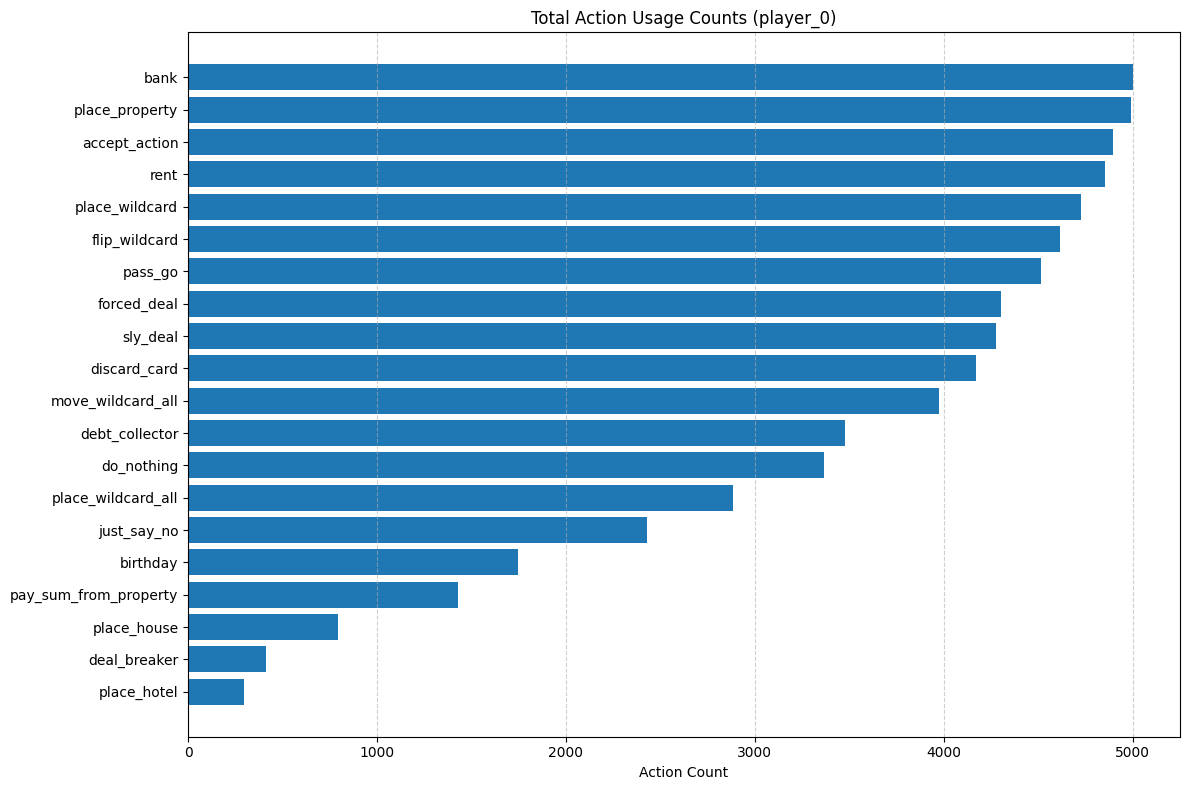

In [7]:
actions, counts = zip(*sorted(total_action_counts["player_0"].items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(actions, counts)
plt.xlabel("Action Count")
plt.title("Total Action Usage Counts (player_0)")
plt.gca().invert_yaxis()  # Most frequent action at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

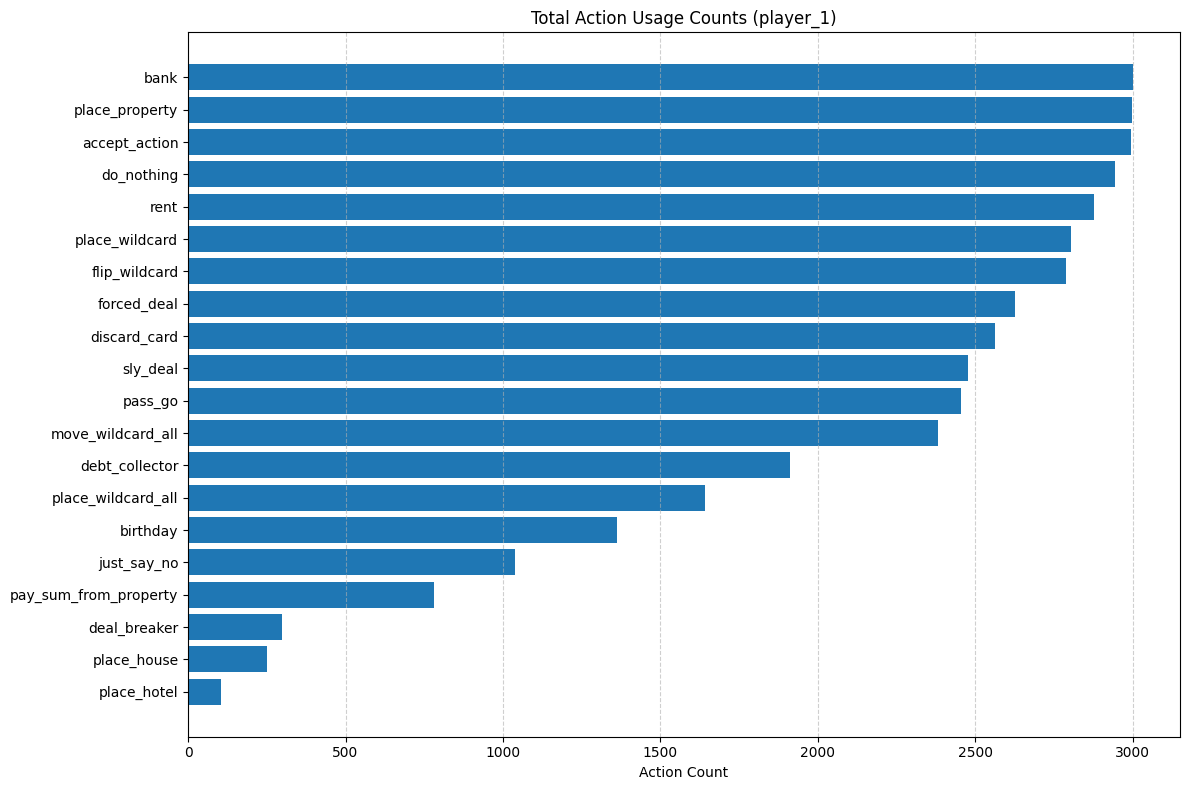

In [8]:
actions, counts = zip(*sorted(total_action_counts["player_1"].items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(actions, counts)
plt.xlabel("Action Count")
plt.title("Total Action Usage Counts (player_1)")
plt.gca().invert_yaxis()  # Most frequent action at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


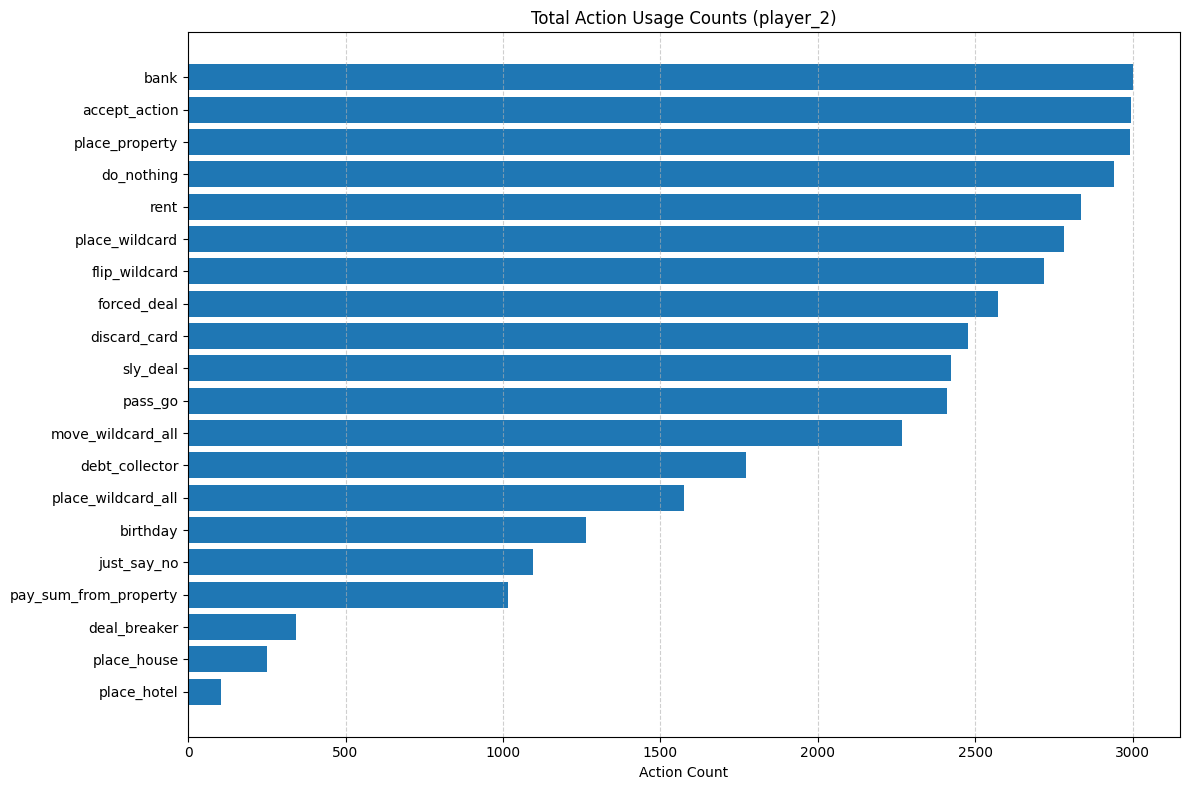

In [9]:
actions, counts = zip(*sorted(total_action_counts["player_2"].items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(actions, counts)
plt.xlabel("Action Count")
plt.title("Total Action Usage Counts (player_2)")
plt.gca().invert_yaxis()  # Most frequent action at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()